# "Chat Generation 2: Electric Bugaloo"
> Revisiting chat generation after the fastai NLP lesson

- toc: true
- badges: true
- comments: true
- author: Matt Bowen
- categories: [jupyter]
- comments: true

## Introduction

In my [first real post](https://bobowedge.github.io/adventures-in-telework/pytorch/jupyter/2020/11/12/chat_generation.html), I tried my hand at generating fake chat logs using PyTorch. The corpus I used was a private Google Hangouts chatroom that I'm in and my idea was ostensibly to generate something that resembled the message in that room. I adapted one of the PyTorch examples to attempt to do so. I was able to generate a model, but, as you can see from the results at the bottom of the post, the result wasn't all that great.

Today, I'm going to try again, now armed with the last lesson in the [fastai course](https://course.fast.ai/), which covers natural language processing (NLP). 

In [64]:
#collapse
from fastai.text.all import *

## Data Prep

> Warning: Some of the chat content may contain profanity or stupidity.

The previous post on chat generation did most of the leg work in terms of prepping the data to interact nicely with the `fastai` interface, but I did a couple of more things to make training and generation easier.

First, I added in a couple of special marker words to indicate the speaker (`xxsender`) and the start (`xxsom`) and the end (`xxeom`) of messages. Then, I combined them into a single string for each message:

In [48]:
##
# Special marker words
mark1 = "xxsender"
mark2 = "xxsom"
mark3 = "xxeom"

# Read in the data and create
chat_df = pd.read_csv("chat_file.csv")
chat_df['Text'] = f"{dlm1} " + chat_df['Sender'] + f" {dlm2} " + chat_df["Message"] + f" {dlm3}"
chat_df.head()

,Sender,Message,Text
0,Kappa,Rsvp allo,xxsender Kappa xxsom Rsvp allo xxeom
1,Omega,"Is it dead, did you get my last AliExpress find?","xxsender Omega xxsom Is it dead, did you get my last AliExpress find? xxeom"
2,Kappa,I didn't see it and it wouldn't let me send anything,xxsender Kappa xxsom I didn't see it and it wouldn't let me send anything xxeom
3,Omega,<MEME>,xxsender Omega xxsom <MEME> xxeom
4,Kappa,I need this,xxsender Kappa xxsom I need this xxeom


From there, I needed to break up the corpus into training and validation sets. I made each training and validation file to be a chunk of 100 consecutive messages concatenated together. Hopefully, this will preserve some of the inter-message dynamics, but keep each file reasonably sized. (The number 100 is quite arbitrary.)

In [57]:
##
# Somewhat arbitrary parameters
msgs_per_chunk = 100
train_percent = 0.8
valid_percent = 1.0 - train_percent

total_msgs = len(chat_df)
train_msgs = int(total_msgs * train_percent)
valid_msgs = total - train_msgs
print(total_msgs, train_msgs, valid_msgs)

# Chunk messages into separate files
for i in range(0, total_msgs, msgs_per_chunk):
    subset = " ".join(chat_df['Text'][i:i+msgs_per_chunk])
    if i < train_msgs:
        txt_file = f"data/train/{i}.txt"
    else:
        txt_file = f"data/valid/{i}.txt"
    with open(txt_file, mode='w') as f:
        f.write(subset)

29000 23200 5800


## Training a model

With the data prep done, the next step is to train a language model. First, I created a `DataLoaders` object based on the training and validation sets to batch to give it to the language model learner

In [59]:
path = "data"
get_data = partial(get_text_files, folders=['train', 'valid'])
dls_lm = DataBlock(
    blocks = TextBlock.from_df(path, is_lm=True),
    get_items=get_data, splitter=RandomSplitter(0.1)).dataloaders(path, path=path, bs=64, seq_len=80)

In [60]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos xxsender xxmaj gamma xxsom no one is in chat today and it 's terrible xxeom xxsender xxmaj kappa xxsom xxup sad xxeom xxsender xxmaj gamma xxsom so xxeom xxsender xxmaj kappa xxsom xxmaj why even have rules of we do nt follow them xxeom xxsender xxmaj gamma xxsom better idea for the end of last night 's episode xxeom xxsender xxmaj kappa xxsom xxmaj this country is a dump xxeom xxsender xxmaj gamma xxsom jon tells dany who he,xxsender xxmaj gamma xxsom no one is in chat today and it 's terrible xxeom xxsender xxmaj kappa xxsom xxup sad xxeom xxsender xxmaj gamma xxsom so xxeom xxsender xxmaj kappa xxsom xxmaj why even have rules of we do nt follow them xxeom xxsender xxmaj gamma xxsom better idea for the end of last night 's episode xxeom xxsender xxmaj kappa xxsom xxmaj this country is a dump xxeom xxsender xxmaj gamma xxsom jon tells dany who he really
1,"time until the election voting against their other xxunk until they get to him xxeom xxsender xxmaj beta xxsom xxmaj it seems that it 's convention for xxmaj senators to xxunk from voting in conflict of interest cases , not law or even xxmaj senate rules . xxmaj so , xxmaj cruz could vote for himself . xxmaj he does n't have to resign as senator until he 's actually xxunk xxeom xxsender xxmaj kappa xxsom < meme > xxeom","until the election voting against their other xxunk until they get to him xxeom xxsender xxmaj beta xxsom xxmaj it seems that it 's convention for xxmaj senators to xxunk from voting in conflict of interest cases , not law or even xxmaj senate rules . xxmaj so , xxmaj cruz could vote for himself . xxmaj he does n't have to resign as senator until he 's actually xxunk xxeom xxsender xxmaj kappa xxsom < meme > xxeom xxsender"


Then, I fed that object into the language model learner to create a language model to train. As with other `fastai` models, this sets up a pretrained model that can be fine tuned to based on the particular context.

In [61]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

I used the learning rate finder to pick an apporpriate learning rate:

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.0831763744354248)

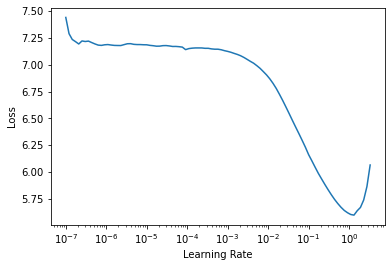

In [62]:
learn.lr_find()

Now, I fit the model, using that learning rate and 10 epochs:

In [74]:
epochs = 10
lr = 1e-1
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.602012,3.350408,0.388268,28.514360,00:58
1,3.726574,3.723708,0.366895,41.417671,00:58
2,3.399452,3.705886,0.370592,40.686092,00:57
3,3.176552,3.566556,0.382298,35.394474,00:57
4,2.986681,3.432734,0.391250,30.961184,00:58
5,2.807675,3.359524,0.406797,28.775505,00:57
6,2.646611,3.322854,0.415332,27.739414,00:59
7,2.482075,3.298300,0.421074,27.066593,00:57
8,2.355381,3.294302,0.422982,26.958590,00:58
9,2.265341,3.295616,0.423320,26.994041,00:58


Again, 10 epochs is arbitrary, merely based on the fact that epoch took about a minute and 10 minutes isn't an eternity to wait.

## Output Cleanup

Before I generated text, I need a routine to clean the output to make it look reasonable. In particular, I had added those extra `xx` markers that needed to be removed. Additionally, there were some modifications that the default tokenizer for `fastai` uses (e.g. `It's` to `It 's`) that needed to be undone. One thing I couldn't find in the `fastai` library was something to completely undo that tokenization. 

For those reasons, the collapse below has the `output_cleanup` function that I wrote to make the generated text prettier. It's not very interesting, but I included it for completeness

## Chat Generation

With the model tuned, I have everything I need to generate some chat. The main function for doing so is `learn.predict`, which generates some words based on some seed text. Here's the generation function that I came up with:

In [76]:
##
# Generate some chat
def generate(seed, num_words):
    # If seed is just a sender, add the sender marker
    if seed in ["Kappa", "Gamma", "Psi", "Omega", "Beta", "Sigma"]:
        seed = "xxsender " + seed
    # Predict slightly past the number of requested words
    x = learn.predict(seed, num_words + 20, temperature=0.75)
    # Clean the output
    x = output_cleanup(x)
    # Trim back to the last complete message
    x = x.splitlines()
    x = "\n".join(x[:-1])
    return x 

In [78]:
print(generate("", 200))

 Gamma :: it iirc made MIL as ron burgundy
 Gamma :: well, they all don't have their own non white children
 Omega :: They've been there since last year
 Beta :: If they do nt have a non - emergency situation, that's gold
 Kappa :: It's a silent auction
 Kappa :: It's a shame that that's not the origin for this
 Kappa :: Does that matter?
 Kappa :: is this it?
 Kappa :: I'm beginning to doubt her dad as a conservative but that doesn't mean it is a good one
 Gamma :: i think it's not a nut roll
 Omega :: i mean the maybe i assume that's the third time i was being a retard
 Kappa :: it's like a fighting chance to remember it
 Gamma :: It's really good
 Kappa :: I'm out of my house


It's pretty easy to see that this generated chat is better than the previous text generation that I did. At a minimum, each message is much more likely to be coherent as English. There is also some continuity between messages, where there was none before.

For fun, I also generated some text seeded based on who the first sender was

In [47]:
for sender in ["Kappa", "Gamma", "Psi", "Omega", "Beta", "Sigma"]:
    y = generate(sender, 100)
    print(y)
    print("--------------------------------")

 Kappa :: But i can not keep forgetting 
 Gamma :: i guess it's not illegal if you don't think we're gonna go to the gov't 
 Kappa :: The pediatrician said it was never before 
 Kappa :: There's a spider in the CO 
 Kappa :: just the fuck 
 Kappa :: Fucking retarded 
 Kappa :: Maybe i'm also retarded 
 Gamma :: It's a retarded demon 
 Kappa :: i was retarded 
 Kappa :: That s a good word 
--------------------------------


 Gamma :: Too accurate 
 Kappa :: This is one of the most advanced things i've ever seen 
 Kappa :: how are you going to take the call? 
 Gamma :: Fuck this country 
 Kappa :: Fuck this country 
 Kappa :: My question is how to get on 
 Kappa :: The question from the south is why someone said there's a higher school 
 Kappa :: Oh and i mean, people in the south are going to wait for the Canadian man who lives there 
--------------------------------


 Psi :: JFC 
 Psi :: <MEME> 
 Kappa :: Is this a fun time, don't have a job? 
 Gamma :: The fuck 
 Kappa :: Lol 
 Kappa :: i hate this world 
 Gamma :: Boris might always have COVID 
 Kappa :: I'm not going to buy it 
 Kappa :: i'm like being real and retarded 
 Kappa :: i assume that's some good social commentary 
 Kappa :: and then it's called someone's 
--------------------------------


 Omega :: So i can get a pass to bring myself to a free crab event today 
 Omega :: Yeah i have a fever, so, just because of a fever, i need the best for my life 
 Kappa :: It's like a normal person 
 Omega :: There's a lot of thoughts on what you've done 
 Omega :: Ok 
 Omega :: Maybe they're a family 
 Omega :: Or the other way 
--------------------------------


 Beta :: Damn it, it's so easy to do 
 Omega :: Everyone is like a lot of people playing at the prison 
 Omega :: That's you really about putting no Clown on the table 
 Psi :: Also, he's the end of America :: i think it's the narrative"
 Kappa :: That s a good cartoon for "hot people" he's "to be" so very wise of point 
 Kappa :: Good spin on this web comic 
--------------------------------


 Sigma :: i have no clue what the assignment is 
 Omega :: The ravens are not playing their game 
 Gamma :: They are going to vote for him, and nothing else will be shady 
 Omega :: He needs to be dead 
 Gamma :: And he's not subtle 
 Kappa :: Is the game reopened? 
 Psi :: Lighting beacons 
 Omega :: Yes it is 
 Omega :: But the beacons are lit 
 Kappa :: Beacon lit 
--------------------------------


## Takeaway

My primary takeaway is that this version of text generation is better in multiple ways. First, it generates objectively more reasonable text. It's not perfect and still identifiable as machine-generated, but it is definitely better than my previous attempt. Second, the entire process was much easier and there's a lot less code to write.  With my first attempt with PyTorch, training a model took a lot of work to adapt their example to my data. For this attempt, it's less than 20 lines of actual code (ignoring the output cleanup).